In [0]:
# # NVIDIA profiling tool for the available GPU
# !nvidia-smi
# # CLone my repo that contains the shell file
# !git clone https://gist.github.com/f7b7c7758a46da49f84bc68b47997d69.git
#   # CLone my repo that contains the shell file
# !git clone https://gist.github.com/f7b7c7758a46da49f84bc68b47997d69.git
# !wget https://developer.nvidia.com/compute/cuda/9.2/Prod2/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.148-1_amd64
# !dpkg --install cuda-repo-ubuntu1604-9-2-local_9.2.148-1_amd64
# !apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
# !apt-get update
# # NOTE: This might take some time..
# !apt-get install cuda
# # Check the version of CUDA on the system
# !cat /usr/local/cuda/version.txt
# !pip install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
# !pip install torchvision
# # Use PyTorch to check versions, CUDA version and cuDNN

# import torch

# print("PyTorch version: ")
# print(torch.__version__)
# print("CUDA Version: ")
# print(torch.version.cuda)
# print("cuDNN version is: ")
# print(torch.backends.cudnn.version())
# !nvidia-smi

In [0]:
from tqdm import tqdm_notebook as tqdm

import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import pandas as pd
import re
# from google.colab import files


plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

torch.manual_seed(42)
np.random.seed(42)

In [0]:
!curl -L -o vocabulary.txt https://drive.google.com/uc?id=1jr7WDwgi0IZDidiRsXuqfDnk17dQXx4X
!curl -L -o val_df.csv https://drive.google.com/uc?id=1q-RqMEhWHQS28nT_Ajf8CfuWJsFdzJwk

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:01:00 --:--:--     0
curl: (35) OpenSSL SSL_connect: SSL_ERROR_SYSCALL in connection to drive.google.com:443 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:01:00 --:--:--     0
curl: (35) OpenSSL SSL_connect: SSL_ERROR_SYSCALL in connection to drive.google.com:443 


In [0]:
vocabulary = open('vocabulary.txt', 'r').read()
train = [word for word in vocabulary.split('\n')]
val_df = pd.read_csv('val_df.csv')

In [0]:
val_df.head()

,raw_ngram,year,match_count,volume_count,idx,n_gram,new_idx,is_bastard,new_ngram
0,АКАДЕНШ,1836,1,1,a,АКАДЕНШ,NaN,1.0,АКАДЕМІИ
1,АРОДНОЕ,1885,2,2,a,АРОДНОЕ,NaN,1.0,НАРОДНОЕ
2,Авгуота_NOUN,1835,1,1,a,Авгуота,NaN,1.0,Августа
3,Августь_NOUN,1782,1,1,a,Августь,NaN,1.0,Августъ
4,Австрж_NOUN,1813,2,1,a,Австрж,NaN,1.0,Австріи


In [0]:
len(val_df)

207

In [0]:
train_words = [word for word in shuffle(train) if len(word)>4]
test_words = [word.lower() for word in val_df['n_gram'].astype(str).tolist() if word]

In [0]:
train_words[:10]

['отприсегнутися',
 'камнемъ',
 'механику',
 'постигшая',
 'арсеналами',
 'хулиганы',
 'древний',
 'предоставлять',
 'давилась',
 'выйся']

In [0]:
len(train_words)

161556

In [0]:
test_words[:10]

['акаденш',
 'ародное',
 'авгуота',
 'августь',
 'австрж',
 'агаоангела',
 'аеанасьевской',
 'аеонасш',
 'аеонт',
 'аиз1ганап']

In [0]:
class Vocabulary:
    def __init__(self, data):
        self.AUXILIARY = ["^", "<pad>", "$", "<unk>"]
        self.data = data
        self.chars, self.char2idx, self.idx2char = self.fit(data)
        self.words, self.num_words = self.distinct_words(data)
        self.vocab_size = len(self.chars)
        self.pad_len = self.define_pad()
        
    def fit(self, data):
        """Extract unique symbols from the data, make itos (item to string) and stoi (string to index) objects"""
        chars = list(set(list(',-.0123456789í́абвгдеёжзийклмнопрстуфхцчшщъыьэюяіѣѳѵ') + \
                         [char for word in data for char in word if not self.not_russian(word)]))
        chars = self.AUXILIARY + sorted(chars)
        char2idx = {s: i for i, s in enumerate(chars)}
        idx2char = {i: s for i, s in enumerate(chars)}
        
        return chars, char2idx, idx2char
      
    def distinct_words(self, data):
        print('Estimating cospus size')
        counts = Counter(data)
        words = list(set([word for word in data if len(word)>4 and not self.not_russian(word)]))
        num_words = len(words)
        print('Done!')
        print('You can checkout the number of corpus words and the words themselves with commands .num_words, .words')
        return(words, num_words)

    def transform_all(self, words):
        """Transform list of data to list of indices
        Input:
            - data, list of strings
        Output:
            - list of lists of char indices
        """
        return [self.transform_one(word) for word in words]
    
    def transform_one(self, word):
        """Transform data to indices
        Input:
            - data, string
        Output:
            - list of char indices
        """
        return [self.char2idx[char] if char in self.chars else self.char2idx["<unk>"] for char in word.lower()]
    
    def transform_vecs(self, vecs):
        """Transform list of indices to list of data
        Input:
            - list of lists of char indices
        Output:
            - data, list of strings
        """
        return [self.transform_vec(vec) for vec in vecs]
    
    def transform_vec(self, vec):
        """Transform indices to data
        Input:
            - list of char indices
        Output:
            - data, string
        """
        return "".join([self.idx2char[int(idx)] for idx in vec])
      
    def define_pad(self):
      
        word_lens = [len(x) for x  in self.transform_all(self.words)]
        return(max(word_lens))
      
    def not_russian(self, string):
        s = re.sub("[.,:\'-]", '', string)
        charRe = re.compile(r'[a-zA-Z0-9.]')
        st = charRe.search(s)
        return bool(st) or bool(re.search(r'\d', s) or bool(re.search(r'[^a-zа-яё ]+', string)))

In [0]:
V = Vocabulary(train_words)

Estimating cospus size
Done!
You can checkout the number of corpus words and the words themselves with commands .num_words, .words


In [0]:
V.vocab_size

56

In [0]:
V.num_words

161556

In [0]:
V.pad_len

27

In [0]:
V.transform_all(['австріи', 'жэк'])

[[19, 21, 36, 37, 35, 52, 27], [25, 48, 29]]

In [0]:
class CharDataset(Dataset):
    def __init__(self, data, V):
        super(Dataset).__init__()
        self.V = V
        self.chars = V.chars
        self.data = data
        self.pad_len = V.pad_len
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        word = self.data[idx]
        indices = self.V.transform_one(word)
        x = torch.ones((self.pad_len), dtype=torch.int64)
        y = torch.ones((self.pad_len), dtype=torch.int64)
        mask = torch.zeros((1,), dtype=torch.int64)
        word_len = min(len(indices), self.pad_len-1)
        for idx_i, i in enumerate(indices[:word_len-1]):
            x[idx_i+1] = i
            
        for idx_i, i in enumerate(indices[:word_len]):
            y[idx_i] = i
            
        mask[0] = word_len+1
            
        x[0] = self.V.char2idx["^"]
        y[word_len] = self.V.char2idx["$"]
        
        
        return x, y, mask
    
    def gen_input_tensor(self, letters):
        indices = self.V.transform_one(letters)
        tensor = torch.ones((self.pad_len), dtype=torch.int64)
        word_len = min(len(indices), self.pad_len)
        for idx_i, i in enumerate(indices[:word_len]):
            tensor[idx_i+1] = i
            
        tensor[0] = 0
            
        return tensor
    
    def resized(self, new_size):
        return CharDataset(data=self.data[:new_size], V=self.V)

In [0]:
class CharLM(nn.Module):
    def __init__(self, vocab_size, emb_dim=27, hidden_size=128, n_layers=2, drop_prob=0.5, word_len=27):
        super(CharLM, self).__init__()
        self.vocab_size = vocab_size
        self.word_len = word_len
        self.emb_dim = emb_dim
        self.hidden_size = hidden_size
        self.n_layers=n_layers
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(self.emb_dim, hidden_size, num_layers=self.n_layers, batch_first=True) #,dropout=drop_prob)#, bidirectional=True)
        self.output = nn.Linear(in_features=self.word_len*self.hidden_size, out_features=self.vocab_size*word_len)
    
    def forward(self, input_word):
        # torch.Size([64, 27])
        embeded = self.emb(input_word).view(-1, self.word_len, self.emb_dim)
        # torch.Size([64, 27, 27]) or torch.Size([1, 27, 27])
        out, hidden = self.lstm(embeded)
        # torch.Size([64, 27, 1024])
        batch_size, seq_size, hidden_size = out.shape
        out = out.contiguous().view(batch_size, seq_size*hidden_size)
        # torch.Size([64, 13824])
        out = self.output(out).view(-1, self.word_len, self.vocab_size)
        # torch.Size([64, 27, 55])
        final = F.softmax(out, dim=-1)
        # torch.Size([64, 27,55])
        return final
      
        
class CharLinearModel(nn.Module):
    def __init__(self, vocab_size, emb_dim=27, hidden_size=128, word_len=27):
        super(CharLinearModel, self).__init__()
        self.vocab_size = vocab_size
        self.word_len = word_len
        self.emb_dim = emb_dim
        self.emb = nn.Embedding(embedding_dim=emb_dim, num_embeddings=vocab_size)
        self.hidden = nn.Linear(in_features=self.word_len*self.emb_dim, out_features=hidden_size)
        self.output = nn.Linear(in_features=hidden_size, out_features=vocab_size*word_len)
        
    def forward(self, input_word): 
        # torch.Size([64, 15])
        input_word = self.emb(input_word)
        # torch.Size([64, 15, 15])
        input_word = input_word.view(-1, self.word_len*self.emb_dim)
        # torch.Size([64, 225])
        hidden = F.relu(self.hidden(input_word)) 
        # torch.Size([64, 1024])
        final = self.output(hidden).view(-1, self.word_len, self.vocab_size) 
        # torch.Size([64, 15, 38])
        final = F.softmax(final, dim=-1) 
        # torch.Size([64, 15, 38])
        return final

In [0]:
class MaskedLoss(nn.Module):
    def __init__(self, base_criterion=nn.CrossEntropyLoss()):
        super(MaskedLoss, self).__init__()
        self.base_criterion=base_criterion
        
    def forward(self, predict, target, mask):
        batch_size = predict.shape[0]
        loss = []
        for batch_id in torch.arange(batch_size):
            word_len = mask[batch_id][0]
            
            word_loss = torch.stack([
                self.base_criterion(
                    predict[batch_id:batch_id+1, idx, :],
                    target[batch_id:batch_id+1, idx]
                ) for idx in torch.arange(word_len)
            ])
            
            word_loss = torch.mean(word_loss)
            loss.append(word_loss)
        loss = torch.mean(torch.stack(loss))
        return loss

In [0]:
train_dataset = CharDataset(V.words[:int(0.995*(len(V.words)))], V)
val_dataset = CharDataset(V.words[int(0.995*(len(V.words))):], V)

In [0]:
len(train_dataset)

160748

In [0]:
len(val_dataset)

808

In [0]:
for i in np.random.choice(800, size=5):
    print(f"Example {i}")
    print("X: ", V.transform_vec(train_dataset[i][0].numpy()))
    print("Y: ", V.transform_vec(train_dataset[i][1].numpy()))
    print("="*40)

Example 629
X:  ^прикован<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Y:  прикована$<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Example 212
X:  ^волшебных<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Y:  волшебныхъ$<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Example 553
X:  ^взят<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Y:  взяты$<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Example 68
X:  ^сборищах<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Y:  сборищахъ$<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Example 444
X:  ^дразн<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = CharLM(V.vocab_size, word_len=V.pad_len, emb_dim=128, hidden_size=128)
# model = CharLinearModel(V.vocab_size, V.pad_len, 1024, word_len=V.pad_len)
model.to(device)
criterion = nn.CrossEntropyLoss()
loss_func = MaskedLoss(criterion)
optimizer = opt.Adam(lr=0.001, params=model.parameters())
lr_sched = opt.lr_scheduler.ReduceLROnPlateau(optimizer, patience=7, verbose=True, threshold=0.001)

In [0]:
# from google.colab import files
# files.upload()

In [0]:
train_losses = []
train_perplexes = []

dev_losses = []
dev_perplexes = []

early_stopping_values = [999]
early_stopping_count = 0
early_stopping_trigger = 7

model_filename = "old_rus_lm.pth"

dataset_size = 10000
batch_size = 64
n_epochs = 200
# train_loader = DataLoader(dataset=train_dataset.resized(2000), batch_size=batch_size, num_workers=8)
# val_loader = DataLoader(dataset=val_dataset.resized(200), batch_size=batch_size, num_workers=4)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=20)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=4)

In [0]:
for ep in range(n_epochs):
    model.train()
    epoch_loss = []
    epoch_perplexes = []
    for x, y, mask in tqdm(train_loader, desc='Training'):
        x = x.to(device)
        y = y.to(device)
        word = model(x)
        loss = loss_func(word, y, mask)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_value = loss.detach().cpu().numpy()
        perplexity_value = torch.pow(loss.detach(), 2).cpu().numpy()
        
        epoch_loss.append(loss_value)
        epoch_perplexes.append(perplexity_value)
        
    mean_train_loss = np.mean(epoch_loss)
    mean_train_perplexity = np.mean(epoch_perplexes)
        
    val_losses = []
    val_perplexes = []
    model.eval()
    with torch.no_grad():
        for x, y, mask in tqdm(val_loader, desc='Validating'):
            x = x.to(device)
            y = y.to(device)

            word = model(x)
            loss = loss_func(word, y, mask)

            loss_value = loss.cpu().numpy()
            perplexity_value = torch.pow(loss, 2).cpu().numpy()

            val_losses.append(loss_value)
            val_perplexes.append(perplexity_value)
            
    mean_val_loss = np.mean(val_losses)
    mean_val_perplexity = np.mean(val_perplexes)
    
    lr_sched.step(mean_val_loss)
    
    if mean_val_loss <= min(early_stopping_values):
        early_stopping_values.append(mean_val_loss)
        print("Quality improved. Saving Model.")
        torch.save(model.state_dict(), model_filename)
#         files.download(model_filename)
        
        early_stopping_count = 0
    else:
        early_stopping_count += 1
        early_stopping_values.append(mean_val_loss)
        if early_stopping_count >= early_stopping_trigger:
            print(f"Early stopping triggered, minimal loss reached = {min(early_stopping_values)}")
            break
            
    train_perplexes.append(mean_train_perplexity)
    train_losses.append(mean_train_loss)
    dev_perplexes.append(mean_val_perplexity)
    dev_losses.append(mean_val_loss)

    print(f"Epoch {ep}:\n train_loss={mean_train_loss:.5f},"\
          f" train_perplexity={mean_train_perplexity:.5f},\n"\
          f" val_loss={mean_val_loss:.5f},"\
          f" val_perplexity={mean_val_perplexity:.5f}")


Quality improved. Saving Model.
Epoch 0:
 train_loss=3.30060, train_perplexity=10.97883,
 val_loss=3.11577, val_perplexity=9.70808



Quality improved. Saving Model.
Epoch 1:
 train_loss=3.11348, train_perplexity=9.69381,
 val_loss=3.11452, val_perplexity=9.70029



Quality improved. Saving Model.
Epoch 2:
 train_loss=3.11252, train_perplexity=9.68784,
 val_loss=3.11374, val_perplexity=9.69543



Quality improved. Saving Model.
Epoch 3:
 train_loss=3.11208, train_perplexity=9.68512,
 val_loss=3.11221, val_perplexity=9.68589



Quality improved. Saving Model.
Epoch 4:
 train_loss=3.11176, train_perplexity=9.68314,
 val_loss=3.11218, val_perplexity=9.68572



Epoch 5:
 train_loss=3.11145, train_perplexity=9.68118,
 val_loss=3.11274, val_perplexity=9.68920



Epoch 6:
 train_loss=3.11108, train_perplexity=9.67887,
 val_loss=3.11326, val_perplexity=9.69239



Quality improved. Saving Model.
Epoch 7:
 train_loss=3.11083, train_perplexity=9.67733,
 val_loss=3.11132, val_perplexity=9.68034



Epoch 8:
 train_loss=3.11076, train_perplexity=9.67691,
 val_loss=3.11263, val_perplexity=9.68849



Epoch 9:
 train_loss=3.11064, train_perplexity=9.67612,
 val_loss=3.11298, val_perplexity=9.69067



Epoch 10:
 train_loss=3.11049, train_perplexity=9.67521,
 val_loss=3.11328, val_perplexity=9.69255



Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11:
 train_loss=3.10968, train_perplexity=9.67016,
 val_loss=3.11146, val_perplexity=9.68124



Quality improved. Saving Model.
Epoch 12:
 train_loss=3.10893, train_perplexity=9.66547,
 val_loss=3.11120, val_perplexity=9.67960



Quality improved. Saving Model.
Epoch 13:
 train_loss=3.10866, train_perplexity=9.66386,
 val_loss=3.11075, val_perplexity=9.67680



Quality improved. Saving Model.
Epoch 14:
 train_loss=3.10846, train_perplexity=9.66258,
 val_loss=3.11069, val_perplexity=9.67643



Quality improved. Saving Model.
Epoch 15:
 train_loss=3.10831, train_perplexity=9.66162,
 val_loss=3.11057, val_perplexity=9.67570



Epoch 16:
 train_loss=3.10817, train_perplexity=9.66079,
 val_loss=3.11083, val_perplexity=9.67731



Epoch 17:
 train_loss=3.10806, train_perplexity=9.66009,
 val_loss=3.11089, val_perplexity=9.67767



Epoch 18:
 train_loss=3.10797, train_perplexity=9.65956,
 val_loss=3.11098, val_perplexity=9.67822



Epoch    19: reducing learning rate of group 0 to 1.0000e-05.
Epoch 19:
 train_loss=3.10790, train_perplexity=9.65908,
 val_loss=3.11100, val_perplexity=9.67839



Epoch 20:
 train_loss=3.10785, train_perplexity=9.65881,
 val_loss=3.11103, val_perplexity=9.67854



Epoch 21:
 train_loss=3.10782, train_perplexity=9.65858,
 val_loss=3.11105, val_perplexity=9.67867



Early stopping triggered, minimal loss reached = 3.1105728149414062


In [0]:
# files.download(model_filename)

In [0]:
# import os
# os.listdir('.')

In [0]:
# model.load_state_dict(torch.load("old_rus_lm.pth"))

In [0]:
N=10

# Model loss and perplexity on train and dev sets

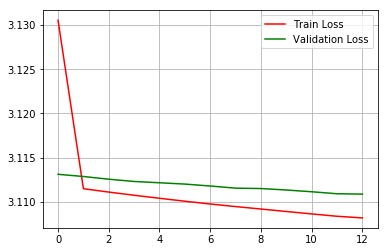

In [0]:
plt.plot(np.convolve(train_losses, np.ones((N,))/N, mode='valid'), "r")
plt.plot(np.convolve(dev_losses, np.ones((N,))/N, mode='valid'), "g")
plt.legend(["Train Loss", "Validation Loss"])
plt.grid()

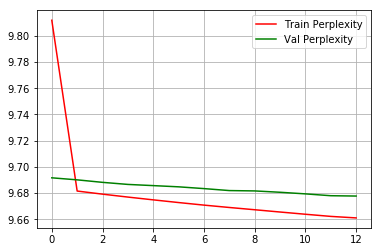

In [0]:
plt.plot(np.convolve(train_perplexes, np.ones((N,))/N, mode='valid'), "r")
plt.plot(np.convolve(dev_perplexes, np.ones((N,))/N, mode='valid'), "g")
plt.legend(["Train Perplexity", "Val Perplexity"])
plt.grid()

# Character probabilites on test set

In [0]:
test_dataset = CharDataset(test_words, V=V)

In [0]:
from functools import reduce

def char_probs(model, dataset, V: V):
    probs_all = []
    for i in range(len(test_dataset)):
        probs = []
        x, y, word_len = dataset[i]
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)[0]
        output = V.transform_vec(y[:word_len])
        for char_idx in range(0,word_len[0]):
            char = output[char_idx]
            if char=='<':
                break
            idx = V.char2idx[char]
            prob = y_pred[char_idx][idx]
            probs.append(prob)
        multiplied = reduce(lambda x, y: x*y, probs)
        final_prob = multiplied/word_len[0].float().to(device)
        
        probs_all.append(final_prob.item())
    return probs_all

In [0]:
val_df['model_prob'] = char_probs(model, test_dataset, V)

In [0]:
val_df.to_csv('val_df.csv')